# Lab 5: Spam Detection

**Deadline**: Thursday, March 12, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Karthik Bhaskar 

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1yJIXbfEMjFlGZCGrgpeEM5uX-mBrfzDQ

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [0]:
file_path = "/content/drive/My Drive/Colab Notebooks/APS360/Lab5/smsspamcollection/"

# a spam message has the label 'spam', and a non-spam message has the label 'ham'

# print an example of a spam SMS
for line in open(file_path + 'SMSSpamCollection'):
    if(line[0:4] == "spam"):
        print("This is a spam message:")
        print(line)
        break

# print an example of a non-spam SMS
for line in open(file_path + 'SMSSpamCollection'):
    if(line[0:3] == "ham"):
        print("This is not a spam message:")
        print(line)
        break

This is a spam message:
spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

This is not a spam message:
ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [0]:
count_spam = 0
count_ham = 0
for line in open(file_path + 'SMSSpamCollection'):
    if(line[0:4] == "spam"):
        count_spam += 1
    elif (line[0:3] == "ham"):
        count_ham += 1

print("There are", count_spam, "spam messages and", count_ham,"non-spam messages")

There are 747 spam messages and 4827 non-spam messages


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

In [0]:
# 2 advantages
"""
- smaller set of data to store: there are significantly fewer letters/numbers/punctuation symbols than there are words
in the English language
- more flexible: better at handling variations in punctuation, spelling, and grammatical structure
"""
# 2 disadvantages
"""
- require a larger model that takes longer to train
- word tokens are more accurate than character tokens: you can gain contextual information about a sentence by examining 
neighboring words, which is not possible with character tokens
"""

'\n- require a larger model that takes longer to train\n- word tokens are more accurate than character tokens: you can gain contextual information about a sentence by examining \nneighboring words, which is not possible with character tokens\n'

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [0]:
import torchtext

text_field = torchtext.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset(file_path + "SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

#dataset[0].sms
#dataset[0].label
train_data, valid_data, test_data = dataset.split(split_ratio=[0.6, 0.2, 0.2])

print("Total number of samples in dataset:", len(dataset))
print("Number of training samples:", len(train_data))
print("Number of val samples:", len(valid_data))
print("Number of testing samples:", len(test_data))

Total number of samples in dataset: 5572
Number of training samples: 3343
Number of val samples: 1115
Number of testing samples: 1114


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating non-spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [0]:
"""
If the training set is not balanced, then the model can make biased predictions by always predicting the 
sample to be of the larger category. In this lab, this would mean that the model would always predict the 
message to be non-spam rather than spam since there are more non-spam messages than spam. 

If this were done in this lab, the model could achieve an accuracy of 85% without actually learning 
anything, since 85% of the messages are non-spam and 15% of the messages are spam. 
"""

'\nIf the training set is not balanced, then the model can make biased predictions by always predicting the \nsample to be of the larger category. In this lab, this would mean that the model would always predict the \nmessage to be non-spam rather than spam since there are more non-spam messages than spam. \n\nIf this were done in this lab, the model could achieve an accuracy of 85% without actually learning \nanything, since 85% of the messages are non-spam and 15% of the messages are spam. \n'

In [0]:
# save the original training examples
old_train_examples = train_data.examples
# get all the spam messages in `train`
train_spam = []
for item in train_data.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train_data.examples = old_train_examples + train_spam * 6

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [0]:
text_field.build_vocab(train_data)
print(text_field.vocab.stoi, "\n")
print(text_field.vocab.itos)

defaultdict(<function _default_unk_index at 0x7f8e61e79268>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, '0': 14, 'd': 15, '.': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, 'b': 25, '2': 26, '8': 27, 'T': 28, 'k': 29, 'v': 30, 'E': 31, '5': 32, 'C': 33, 'S': 34, 'O': 35, 'I': 36, '4': 37, 'N': 38, '7': 39, 'A': 40, '6': 41, 'x': 42, '3': 43, 'R': 44, '!': 45, '9': 46, ',': 47, 'M': 48, 'W': 49, 'P': 50, 'U': 51, 'L': 52, 'H': 53, 'D': 54, 'B': 55, 'Y': 56, 'F': 57, '/': 58, 'G': 59, "'": 60, '?': 61, '£': 62, '-': 63, '&': 64, ':': 65, 'X': 66, 'z': 67, 'V': 68, 'j': 69, 'K': 70, '*': 71, ')': 72, ';': 73, '+': 74, 'J': 75, '(': 76, 'q': 77, '"': 78, 'Q': 79, '#': 80, '>': 81, '=': 82, '@': 83, 'Z': 84, 'ü': 85, '$': 86, '<': 87, 'Ü': 88, '‘': 89, '[': 90, ']': 91, '|': 92, '\x92': 93, '%': 94, '_': 95, '…': 96, '\x93': 97, '“': 98, '–': 99, '\\': 100, 'é': 101, '\t': 102, '\

In [0]:
"""
text_field.vocab.stoi represents a mapping of strings to numerical identifiers. 

text_field.vocab.itos returns a unique list of strings that have been indexed by their numerical identifiers.
"""

'\ntext_field.vocab.stoi represents a mapping of strings to numerical identifiers. \n\ntext_field.vocab.itos returns a unique list of strings that have been indexed by their numerical identifiers.\n'

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

In [0]:
"""
<unk>: the string token used to represent out-of-vocabulary words
<pad>: the string token used as padding
"""

'\n<unk>: the string token used to represent out-of-vocabulary words\n<pad>: the string token used as padding\n'

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [0]:
np.random.seed(50)
train_iter = torchtext.data.BucketIterator(train_data,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [0]:
for i, batch in enumerate(train_iter):
    if i > 9:
        break
    print("-----Batch:", i, "-----")
    max_length = batch.sms[0].shape[1]
    print("Max length of input sequence in batch", i, ":", max_length)
    num_pad_tokens = [max_length - int(i) for i in batch.sms[1]]
    print("Number of <pad> tokens used in batch", i, ":", sum(num_pad_tokens))
    print("\n")  

-----Batch: 0 -----
Max length of input sequence in batch 0 : 149
Number of <pad> tokens used in batch 0 : 0


-----Batch: 1 -----
Max length of input sequence in batch 1 : 28
Number of <pad> tokens used in batch 1 : 15


-----Batch: 2 -----
Max length of input sequence in batch 2 : 141
Number of <pad> tokens used in batch 2 : 23


-----Batch: 3 -----
Max length of input sequence in batch 3 : 25
Number of <pad> tokens used in batch 3 : 4


-----Batch: 4 -----
Max length of input sequence in batch 4 : 160
Number of <pad> tokens used in batch 4 : 16


-----Batch: 5 -----
Max length of input sequence in batch 5 : 22
Number of <pad> tokens used in batch 5 : 2


-----Batch: 6 -----
Max length of input sequence in batch 6 : 158
Number of <pad> tokens used in batch 6 : 4


-----Batch: 7 -----
Max length of input sequence in batch 7 : 64
Number of <pad> tokens used in batch 7 : 53


-----Batch: 8 -----
Max length of input sequence in batch 8 : 149
Number of <pad> tokens used in batch 8 : 24




# Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [0]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [0]:
# from Tutorial 5
class Lab5RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Lab5RNN, self).__init__()
        self.name = "Lab5RNN"
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes

        self.ident = torch.eye(input_size) # identity matrix for generating one-hot vectors
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # get the one-hot vectors
        x = self.ident[x]
        #x = x.view(-1, x.shape[0])
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        # hyperparameter testing: change the way the output is pooled
        
        #out = self.fc(out[:, -1, :]) # the default one?

        out = torch.max(out, dim = 1)[0] # option 1: max pooling
        out = self.fc(out)

        #out = torch.cat([torch.max(out, dim=1)[0], torch.mean(out, dim=1)], dim=1) # option 2: concatenate max pooling and avg pooling
        #self.fc(out)

        return out

In [0]:
import matplotlib.pyplot as plt

# training helper functions
def get_model_name(name, learning_rate, batch_size, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path

def plot_graph(graph_title, x_label, y_label, num_epochs, training_data, val_data, testing_data = None):
    plt.figure()
    plt.title(graph_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    plt.plot(range(1,num_epochs+1), training_data, label="Training")
    plt.plot(range(1,num_epochs+1), val_data, label="Validation")

    if testing_data != None:
        plt.plot(range(1,num_epochs+1), testing_data, label="Testing")
    plt.legend()
    plt.show()

def plot_acc_and_loss(num_epochs, train_err, val_err, train_loss, val_loss):
    print("\n-------------------------------------GRAPHS-------------------------------------\n")
    print("Accuracy plot of Lab4 Autoencoder")   
    plot_graph("Accuracy", "Number of Epochs", "Accuracy", num_epochs, train_err, val_err)

    print("Loss plot of Lab4 Autoencoder")   
    plot_graph("Loss", "Number of Epochs", "Loss", num_epochs, train_loss, val_loss)

def get_data_loader(train_data, val_data, test_data, batch_size):
    num_workers = 1
    np.random.seed(50) 
    train_iter = torchtext.data.BucketIterator(train_data,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
    val_iter = torchtext.data.BucketIterator(val_data,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
    test_iter = torchtext.data.BucketIterator(test_data,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

    return train_iter, val_iter, test_iter

In [0]:
#@title train function that was provided
# from Tutorial 5
def train_rnn_network(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for sms, labels in train_loader:
            optimizer.zero_grad()
            pred = model(sms[0])
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
   
    # plotting
    plt.title("Accuracy Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    plt.title("Loss Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

In [0]:
# #@title old training function copied from Lab 4
# from Lab 4
import time

def train_rnn_network(model, train_loader, val_loader, learning_rate=1e-5, batch_size=64, num_epochs=5):
    """ Training loop. You should update this."""
    torch.manual_seed(50)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_err = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)

    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    start_time = time.time()

    for epoch in range(num_epochs):
        for sms, labels in train_loader:
            optimizer.zero_grad()
            pred = model(sms[0])
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()

        train_err[epoch] = get_accuracy(model, train_loader)
        train_loss[epoch] = loss

        if val_loader != None: # for overfitting, val_loader isn't passed in
            for sms, labels in val_loader:
                optimizer.zero_grad()
                pred_val = model(sms[0])
                loss_val = criterion(pred_val, labels)
                optimizer.step()

            val_err[epoch] = get_accuracy(model, val_loader)
            val_loss[epoch] = loss_val

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, learning_rate, batch_size, epoch)
        torch.save(model.state_dict(), model_path)

    end_time = time.time()

    print('Finished Training')
    
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    print("\n------------------------------------TRAINING------------------------------------")
    print("Training accuracy after {} epochs: {}".format(num_epochs, train_err[-1]))
    print("Training loss after {} epochs: {}".format(num_epochs, train_loss[-1]))

    if val_loader != None: # for overfitting, val_loader isn't passed in
        print("\n-----------------------------------VALIDATION-----------------------------------")
        print("Validation accuracy after {} epochs: {}".format(num_epochs, val_err[-1]))
        print("Validation loss after {} epochs: {}".format(num_epochs, val_loss[-1]))
        
    if val_loader != None:
        return num_epochs, train_err, train_loss, val_err, val_loss
    else:
        return num_epochs, train_err, train_loss

# Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [0]:
def get_accuracy(model, data_loader):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """

    """
    data_iter = torchtext.data.BucketIterator(data, 
                                              batch_size=64, 
                                              sort_key=lambda x: len(x.sms), 
                                              repeat=False)
    """

    correct, total = 0, 0
    for i, batch in enumerate(data_loader):
        output = model(batch.sms[0]) # You may need to modify this, depending on your model setup
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(batch.label.view_as(pred)).sum().item()
        total += batch.sms[1].shape[0]
    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

Finished Training
Total time elapsed: 121.75 seconds

------------------------------------TRAINING------------------------------------
Training accuracy after 30 epochs: 0.9020829916352304
Training loss after 30 epochs: 0.3354804813861847

-----------------------------------VALIDATION-----------------------------------
Validation accuracy after 30 epochs: 0.8995515695067264
Validation loss after 30 epochs: 0.33522287011146545

-------------------------------------GRAPHS-------------------------------------

Accuracy plot of Lab4 Autoencoder


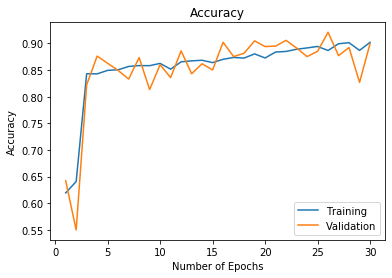

Loss plot of Lab4 Autoencoder


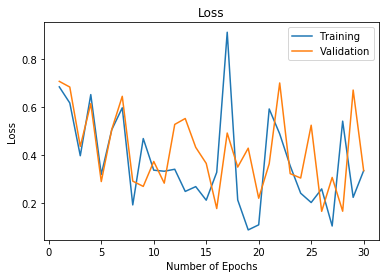

In [0]:
# #@title default

# hyperparameters:
# number of hidden units: 32
# batch size: 32
# learning rate: 1e-4
# number of epochs: 30
# type of output pooling used: the default one
# number of fc layers: 1

# input size of vocab, number of hidden units = 32, 2 output labels (spam or ham)
model = Lab5RNN(len(text_field.vocab), 32, 2)
train_loader, val_loader, test_loader = get_data_loader(train_data=train_data, val_data=valid_data, test_data=test_data, batch_size=32)

# for running the training function provided in the tutorials, uncomment the next line
#train_rnn_network(model, train_loader, val_loader, num_epochs=30, learning_rate=1e-5)

# for running the training funciton you wrote in Lab 4, uncomment the next 2 lines
num_epochs, train_err, train_loss, val_err, val_loss = train_rnn_network(model, train_loader, val_loader, learning_rate=1e-4, batch_size=32, num_epochs=30)
plot_acc_and_loss(num_epochs, train_err, val_err, train_loss, val_loss)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

Finished Training
Total time elapsed: 157.05 seconds

------------------------------------TRAINING------------------------------------
Training accuracy after 30 epochs: 0.8804329998359849
Training loss after 30 epochs: 0.3151156008243561

-----------------------------------VALIDATION-----------------------------------
Validation accuracy after 30 epochs: 0.8914798206278027
Validation loss after 30 epochs: 0.43962737917900085

-------------------------------------GRAPHS-------------------------------------

Accuracy plot of Lab4 Autoencoder


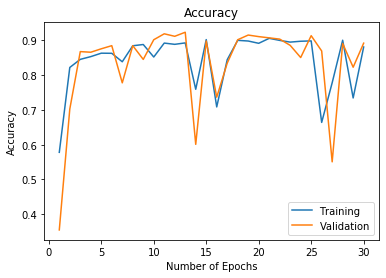

Loss plot of Lab4 Autoencoder


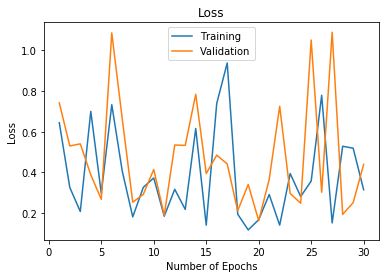

In [0]:
# #@title Model 1

# hyperparameters:
# number of hidden units: 64
# batch size: 32
# learning rate: 1e-4
# number of epochs: 30
# type of output pooling used: the default one
# number of fc layers: 1

# input size of vocab, number of hidden units, 2 output labels (spam or ham)
model1 = Lab5RNN(len(text_field.vocab), 64, 2)
train_loader, val_loader, test_loader = get_data_loader(train_data=train_data, val_data=valid_data, test_data=test_data, batch_size=32)

# for running the training funciton you wrote in Lab 4, uncomment the next 2 lines
num_epochs, train_err, train_loss, val_err, val_loss = train_rnn_network(model1, train_loader, val_loader, learning_rate=1e-4, batch_size=32, num_epochs=30)
plot_acc_and_loss(num_epochs, train_err, val_err, train_loss, val_loss)

Finished Training
Total time elapsed: 150.70 seconds

------------------------------------TRAINING------------------------------------
Training accuracy after 30 epochs: 0.9250451041495817
Training loss after 30 epochs: 0.21404385566711426

-----------------------------------VALIDATION-----------------------------------
Validation accuracy after 30 epochs: 0.9264573991031391
Validation loss after 30 epochs: 0.27350321412086487

-------------------------------------GRAPHS-------------------------------------

Accuracy plot of Lab4 Autoencoder


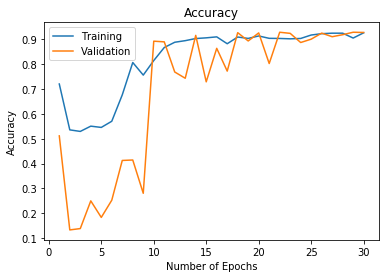

Loss plot of Lab4 Autoencoder


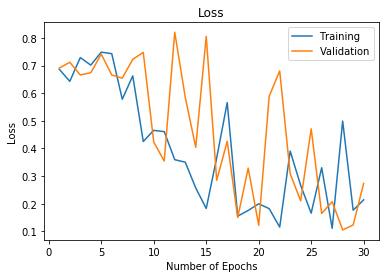

In [0]:
# #@title Model 2

# hyperparameters:
# number of hidden units: 64
# batch size: 32
# learning rate: 1e-4
# number of epochs: 30
# type of output pooling used: max pooling
# number of fc layers: 1

# input size of vocab, number of hidden units, 2 output labels (spam or ham)
model2 = Lab5RNN(len(text_field.vocab), 64, 2)
train_loader, val_loader, test_loader = get_data_loader(train_data=train_data, val_data=valid_data, test_data=test_data, batch_size=32)

# for running the training funciton you wrote in Lab 4, uncomment the next 2 lines
num_epochs, train_err, train_loss, val_err, val_loss = train_rnn_network(model2, train_loader, val_loader, learning_rate=1e-4, batch_size=32, num_epochs=30)
plot_acc_and_loss(num_epochs, train_err, val_err, train_loss, val_loss)

Finished Training
Total time elapsed: 152.85 seconds

------------------------------------TRAINING------------------------------------
Training accuracy after 30 epochs: 0.9811382647203543
Training loss after 30 epochs: 0.07324156910181046

-----------------------------------VALIDATION-----------------------------------
Validation accuracy after 30 epochs: 0.9524663677130045
Validation loss after 30 epochs: 0.16183461248874664

-------------------------------------GRAPHS-------------------------------------

Accuracy plot of Lab4 Autoencoder


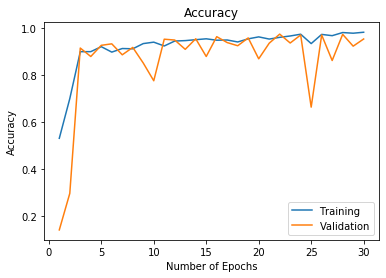

Loss plot of Lab4 Autoencoder


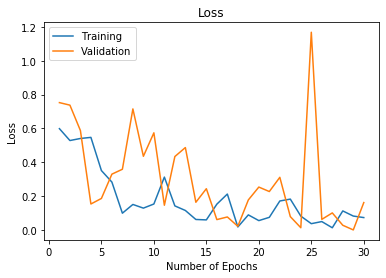

In [0]:
# #@title Model 3

# hyperparameters:
# number of hidden units: 64
# batch size: 32
# learning rate: 5e-4
# number of epochs: 30
# type of output pooling used: max pooling
# number of fc layers: 1

# input size of vocab, number of hidden units, 2 output labels (spam or ham)
model3 = Lab5RNN(len(text_field.vocab), 64, 2)
train_loader, val_loader, test_loader = get_data_loader(train_data=train_data, val_data=valid_data, test_data=test_data, batch_size=32)

num_epochs, train_err, train_loss, val_err, val_loss = train_rnn_network(model3, train_loader, val_loader, learning_rate=5e-4, batch_size=32, num_epochs=30)
plot_acc_and_loss(num_epochs, train_err, val_err, train_loss, val_loss)

Finished Training
Total time elapsed: 137.38 seconds

------------------------------------TRAINING------------------------------------
Training accuracy after 30 epochs: 0.9904871248154831
Training loss after 30 epochs: 0.03874828666448593

-----------------------------------VALIDATION-----------------------------------
Validation accuracy after 30 epochs: 0.8681614349775785
Validation loss after 30 epochs: 0.09611514210700989

-------------------------------------GRAPHS-------------------------------------

Accuracy plot of Lab4 Autoencoder


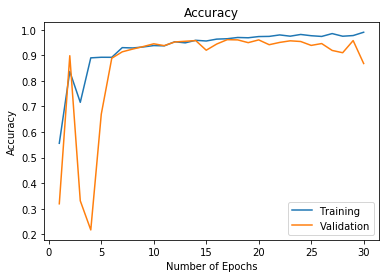

Loss plot of Lab4 Autoencoder


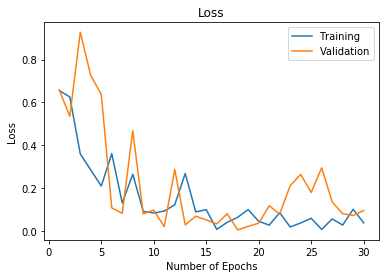

In [0]:
# #@title Model 4
# Model 4

# hyperparameters:
# number of hidden units: 64
# batch size: 40
# learning rate: 7.5e-4
# number of epochs: 30
# type of output pooling used: max pooling
# number of fc layers: 1

# input size of vocab, number of hidden units, 2 output labels (spam or ham)
model4 = Lab5RNN(len(text_field.vocab), 64, 2)
train_loader, val_loader, test_loader = get_data_loader(train_data=train_data, val_data=valid_data, test_data=test_data, batch_size=40)

num_epochs, train_err, train_loss, val_err, val_loss = train_rnn_network(model4, train_loader, val_loader, learning_rate=7.5e-4, batch_size=40, num_epochs=30)
plot_acc_and_loss(num_epochs, train_err, val_err, train_loss, val_loss)

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [0]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid_data.examples if e.label == 1], # spam messages have a label of 1
    valid_data.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid_data.examples if e.label == 0], # non-spam messages have a label of 0
    valid_data.fields)

# the hyperparameters that gave the best performance are:
# number of hidden units: 64
# batch size: 32
# learning rate: 5e-4
# number of epochs: 30
# type of output pooling used: max pooling
# number of fc layers: 1

np.random.seed(50)
spam_loader = torchtext.data.BucketIterator(valid_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

non_spam_loader = torchtext.data.BucketIterator(valid_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs


model = Lab5RNN(len(text_field.vocab), 64, 2)
model_path = get_model_name(model.name, batch_size=32, learning_rate=5e-4, epoch=29)
state = torch.load(model_path)
model.load_state_dict(state)

spam_acc = get_accuracy(model, spam_loader)
print("False positive rate:", str(1 - spam_acc))

non_spam_acc = get_accuracy(model, non_spam_loader)
print("False negative rate:", str(1 - non_spam_acc))

False positive rate: 0.3819444444444444
False negative rate: 0.005149330587023715


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

In [0]:
"""
false positive: labelling a text message as spam when it wasn't spam
false negative: labelling a text message as non-spam when it was spam

Impact of a false positive: important messages, or messages that aren't spam, end up in the spam folder and you can
miss important information

Impact of a false negative: you get too many spam messages in your main inbox, which can be annoying
"""

# Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [0]:
# the hyperparameters that gave the best performance are:
# number of hidden units: 64
# batch size: 32
# learning rate: 5e-4
# number of epochs: 30
# type of output pooling used: max pooling
# number of fc layers: 1

model = Lab5RNN(len(text_field.vocab), 64, 2)

model_path = get_model_name(model.name, batch_size=32, learning_rate=5e-4, epoch=29)
state = torch.load(model_path)
model.load_state_dict(state)

np.random.seed(50)
test_loader = torchtext.data.BucketIterator(test_data,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

model_acc = get_accuracy(model3, test_loader)
print("Test accuracy is:", model_acc)

Test accuracy is: 0.9515260323159784


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [0]:
# Create a Dataset of only spam validation examples
test_spam = torchtext.data.Dataset(
    [e for e in test_data.examples if e.label == 1], # spam messages have a label of 1
    test_data.fields)
# Create a Dataset of only non-spam validation examples
test_nospam = torchtext.data.Dataset(
    [e for e in test_data.examples if e.label == 0], # non-spam messages have a label of 0
    test_data.fields)

# the hyperparameters that gave the best performance are:
# number of hidden units: 64
# batch size: 32
# learning rate: 5e-4
# number of epochs: 30
# type of output pooling used: max pooling
# number of fc layers: 1

np.random.seed(50)
test_spam_loader = torchtext.data.BucketIterator(test_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

test_no_spam_loader = torchtext.data.BucketIterator(test_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs


# model = Lab5RNN(len(text_field.vocab), 64, 2)
# model_path = get_model_name(model.name, batch_size=32, learning_rate=5e-4, epoch=29)
# state = torch.load(model_path)
# model.load_state_dict(state)

spam_acc_test = get_accuracy(model3, test_spam_loader)
print("False negative rate:", str(1-spam_acc_test))

non_spam_acc_test = get_accuracy(model3, test_no_spam_loader)
print("False positive rate:", str(1-non_spam_acc_test))

False negative rate: 0.3680555555555556
False positive rate: 0.003092783505154628


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [0]:
msg = "machine learning is sooo cool!"

text_field.build_vocab(msg)
tokens = text_field.vocab.stoi

chars = []
for c in msg:
  if tokens[c]:
    chars.append(tokens[c])

chars = torch.tensor(new_sms)
chars = chars.view(-1, len(new_sms))

pred = model3(chars)
optimizer = torch.nn.Softmax()
out = optimizer(pred)

prob = out[0].data[1]
print("The probability that msg is spam is:", prob.numpy())

The probability that msg is spam is: 0.0017175472


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

In [0]:
"""
At first appearance, it seems as though classifying a message as spam or not-spam is easy because a relatively simple 
RNN which trains quickly can easily achieve an accuracy rate in the high-80s or low-90s. However, if you consider the
false negative and false positive rates, the model is actually better at classifying non-spam messages than it at 
classifying spam messages. This is demonstrated by the false negative rate that is much higher than the false
positive rate. 

A simple baseline model could involve tokenizing based on words and not characters, and determining the frequency
with which the words appear in the message. The decision-making part of the baseline model would be based on word 
frequency. For example, words like "winner", "cruise", "reward", "award", or "money" are more likely to appear in 
spam messages than non-spam messages. By comparing the word that appears most frequently in the message with a list 
of words that are common in spam messages, the baseline model could predict whether the message is spam or not.
"""